# USGS Gauge Data Integration for HEC-RAS

This notebook demonstrates how to integrate USGS gauge data with HEC-RAS models using the `ras_commander.usgs` submodule.

**Workflow covered:**
1. Discover USGS gauges within/near a HEC-RAS project extent
2. Retrieve flow and stage time series from USGS
3. Set initial conditions using observed data
4. Create boundary conditions from historic flow data (next phase)
5. Validate model results against observations (next phase)

**Example Projects:**
- Balde Eagle Creek (1D model)
- BaldEagleCrkMulti2D (1D/2D integrated model)

**Target Event:**
- Tropical Storm Lee (September 6-12, 2011) - Major flooding event

## 1. Setup and Imports

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Standard library imports
from datetime import datetime, timedelta

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ras-commander core imports
from ras_commander import (
    init_ras_project, ras, RasCmdr, RasPlan, RasExamples, RasPrj
)
from ras_commander.hdf import HdfProject

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


### USGS Data Integration Verification

**After retrieving USGS data**:

- [ ] Data quality codes reviewed (prefer 'A' approved over 'P' provisional)
- [ ] Time series gaps identified and documented (<10% missing typical)
- [ ] Gauge drainage area comparable to model watershed (ratio <10:1)
- [ ] Period of record includes calibration/validation events

**Data Quality Flags** ([USGS NWIS](https://waterservices.usgs.gov/)):
- **A**: Approved (quality-assured, use directly)
- **P**: Provisional (verify before submittal)
- **e**: Estimated (note in documentation)
- **Ice**: Ice-affected (consider excluding from calibration)

**References**:
- [USGS NWIS Web Services](https://waterservices.usgs.gov/)
- [USGS Water Data for the Nation](https://waterdata.usgs.gov/nwis)
- [USGS Data Quality Codes](https://help.waterdata.usgs.gov/codes-and-parameters)

## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "BaldEagleCrkMulti2D"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# USGS Configuration
USGS_SITE = "03335500"            # USGS gauge site number
START_DATE = "2020-01-01"         # Data start date
END_DATE = "2020-12-31"           # Data end date
ONLINE = True                     # Enable network requests

print(f"Outputs will be saved to project folder after extraction.")

Outputs will be saved to project folder after extraction.


In [3]:
# Install dataretrieval if not available (uncomment to install)
# !pip install dataretrieval

## 2. Extract Example Projects

In [4]:
SUFFIX = "911"  # Notebook identifier
# Extract the Bald Eagle Creek example projects
bald_eagle_2d_path = RasExamples.extract_project(["BaldEagleCrkMulti2D"], suffix=SUFFIX)

print(f"2D Model path: {bald_eagle_2d_path}")

2025-12-29 06:54:44 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2025-12-29 06:54:44 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-29 06:54:45 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-29 06:54:45 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-29 06:54:45 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_911'
2025-12-29 06:54:45 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_911' already exists. Deleting existing folder...
2025-12-29 06:54:45 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_911' has been deleted.
2025-12-29 06:54:46 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site

2D Model path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911


In [5]:
# Initialize the 1D project
init_ras_project(bald_eagle_2d_path, RAS_VERSION)

print(f"Project: {ras.project_name}")
print(f"Plans: {len(ras.plan_df)}")
print(f"Geometries: {len(ras.geom_df)}")
print(f"Unsteady files: {len(ras.unsteady_df)}")

2025-12-29 06:54:46 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\BaldEagleDamBrk.rasmap


Project: BaldEagleDamBrk
Plans: 11
Geometries: 10
Unsteady files: 10


In [6]:
# View plan information
ras.plan_df[['plan_number', 'Plan Title', 'Simulation Date', 'Computation Interval']]

,plan_number,Plan Title,Simulation Date,Computation Interval
0,13,PMF with Multi 2D Areas,"01JAN1999,1200,04JAN1999,1200",30SEC
1,15,1d-2D Dambreak Refined Grid,"01JAN1999,1200,04JAN1999,1200",20SEC
2,17,2D to 1D No Dam,"01JAN1999,1200,06JAN1999,1200",1MIN
3,18,2D to 2D Run,"01JAN1999,1200,04JAN1999,1200",20SEC
4,19,SA to 2D Dam Break Run,"01JAN1999,1200,04JAN1999,1200",20SEC
5,03,Single 2D Area - Internal Dam Structure,"01JAN1999,1200,04JAN1999,1200",30SEC
6,04,SA to 2D Area Conn - 2D Levee Structure,"01JAN1999,1200,04JAN1999,1200",20SEC
7,02,SA to Detailed 2D Breach,"01JAN1999,1200,04JAN1999,1200",10SEC
8,01,SA to Detailed 2D Breach FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC
9,05,Single 2D area with Bridges FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC


In [7]:
# View boundary conditions
ras.boundaries_df[['river_reach_name', 'river_station', 'bc_type', 'Interval']]

,river_reach_name,river_station,bc_type,Interval
0,Bald Eagle Cr.,Lock Haven,Flow Hydrograph,1HOUR
1,Bald Eagle Cr.,Lock Haven,Gate Opening,NaN
2,Bald Eagle Cr.,Lock Haven,Lateral Inflow Hydrograph,1HOUR
3,Bald Eagle Cr.,Lock Haven,Lateral Inflow Hydrograph,1HOUR
4,Bald Eagle Cr.,Lock Haven,Uniform Lateral Inflow Hydrograph,1HOUR
5,Bald Eagle Cr.,Lock Haven,Uniform Lateral Inflow Hydrograph,1HOUR
6,Bald Eagle Cr.,Lock Haven,Lateral Inflow Hydrograph,1HOUR
7,Bald Eagle Cr.,Lock Haven,Lateral Inflow Hydrograph,1HOUR
8,Bald Eagle Cr.,Lock Haven,Uniform Lateral Inflow Hydrograph,1HOUR
9,Bald Eagle Cr.,Lock Haven,Normal Depth,NaN


## 3. Discover USGS Gauges in Project Area

We'll use the project's geographic bounds to find nearby USGS stream gauges.

In [8]:
# Find the geometry HDF file to get project bounds
geom_hdf_files = list(bald_eagle_2d_path.glob("*.g*.hdf"))
print(f"Found geometry HDF files: {geom_hdf_files}")

if geom_hdf_files:
    geom_hdf = geom_hdf_files[0]
    print(f"Using: {geom_hdf.name}")

Found geometry HDF files: [WindowsPath('C:/Users/billk_clb/anaconda3/envs/rascmdr_piptest/Lib/site-packages/examples/example_projects/BaldEagleCrkMulti2D_911/BaldEagleDamBrk.g01.hdf'), WindowsPath('C:/Users/billk_clb/anaconda3/envs/rascmdr_piptest/Lib/site-packages/examples/example_projects/BaldEagleCrkMulti2D_911/BaldEagleDamBrk.g02.hdf'), WindowsPath('C:/Users/billk_clb/anaconda3/envs/rascmdr_piptest/Lib/site-packages/examples/example_projects/BaldEagleCrkMulti2D_911/BaldEagleDamBrk.g03.hdf'), WindowsPath('C:/Users/billk_clb/anaconda3/envs/rascmdr_piptest/Lib/site-packages/examples/example_projects/BaldEagleCrkMulti2D_911/BaldEagleDamBrk.g06.hdf'), WindowsPath('C:/Users/billk_clb/anaconda3/envs/rascmdr_piptest/Lib/site-packages/examples/example_projects/BaldEagleCrkMulti2D_911/BaldEagleDamBrk.g08.hdf'), WindowsPath('C:/Users/billk_clb/anaconda3/envs/rascmdr_piptest/Lib/site-packages/examples/example_projects/BaldEagleCrkMulti2D_911/BaldEagleDamBrk.g09.hdf'), WindowsPath('C:/Users/bil

In [9]:
# Get project bounds in lat/lon (WGS84)
# Note: The Bald Eagle Creek example project doesn't have a CRS defined in the geometry HDF,
# so we use known approximate bounds for the Lock Haven, PA area.

try:
    bounds = HdfProject.get_project_bounds_latlon(geom_hdf, buffer_percent=50)
    west, south, east, north = bounds
    
    # Check if bounds look like projected coordinates (large numbers) vs lat/lon
    if abs(west) > 180 or abs(east) > 180:
        raise ValueError("Bounds appear to be in projected coordinates, not lat/lon")
    
    print(f"Project Bounds (WGS84):")
    print(f"  West:  {west:.6f}")
    print(f"  South: {south:.6f}")
    print(f"  East:  {east:.6f}")
    print(f"  North: {north:.6f}")
except Exception as e:
    print(f"Note: {e}")
    # Use known approximate bounds for Bald Eagle Creek area (Lock Haven, PA)
    west, south, east, north = -77.60, 40.90, -77.30, 41.15
    print(f"\nUsing known bounds for Lock Haven, PA / Bald Eagle Creek area:")
    print(f"  West:  {west:.6f}")
    print(f"  South: {south:.6f}")
    print(f"  East:  {east:.6f}")
    print(f"  North: {north:.6f}")

2025-12-29 06:54:46 - ras_commander.hdf.HdfProject - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\BaldEagleDamBrk.g01.hdf
2025-12-29 06:54:46 - ras_commander.hdf.HdfProject - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\BaldEagleDamBrk.g01.hdf
2025-12-29 06:54:46 - ras_commander.hdf.HdfProject - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\BaldEagleDamBrk.g01.hdf
2025-12-29 06:54:46 - ras_commander.hdf.HdfProject - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\BaldEagleDamBrk.g01.hdf
2025-12-29 06:54:46 - ras_commander.hdf.HdfMesh - INFO - Using e

Project Bounds (WGS84):
  West:  -77.708454
  South: 41.010214
  East:  -77.251087
  North: 41.219666


In [10]:
# Query USGS for stream gauges in the project area
from dataretrieval import waterdata

# Query monitoring locations in the bounding box
gauges_df, metadata = waterdata.get_monitoring_locations(
    bbox=[west, south, east, north],
    site_type_code='ST'  # Stream sites only
)

print(f"Found {len(gauges_df)} USGS stream gauges in the project area")

2025-12-29 06:54:46 - dataretrieval.waterdata.utils - INFO - Requesting: https://api.waterdata.usgs.gov/ogcapi/v0/collections/monitoring-locations/items?site_type_code=ST&skipGeometry=False&limit=10000&bbox=-77.70845429969587%2C41.010213686900734%2C-77.25108651903035%2C41.219666334258264


Found 25 USGS stream gauges in the project area


In [11]:
# Display gauge information
if not gauges_df.empty:
    # Select relevant columns
    display_cols = ['monitoring_location_id', 'monitoring_location_name']
    if 'drain_area_va' in gauges_df.columns:
        display_cols.append('drain_area_va')
    
    print("Available USGS Stream Gauges:")
    display(gauges_df[display_cols])
else:
    print("No gauges found in the project bounds.")
    print("Let's use the known gauges for Bald Eagle Creek:")
    print("  USGS-01547200: Bald Eagle Creek below Spring Creek at Milesburg, PA")
    print("  USGS-01548005: Bald Eagle Creek near Beech Creek Station, PA")
    print("  USGS-01548010: Bald Eagle Creek near Mill Hall, PA")

Available USGS Stream Gauges:


,monitoring_location_id,monitoring_location_name
0,USGS-01545680,"Tangascootack Creek near Lock Haven, PA"
1,USGS-01545700,"Queens Run near Lock Haven, PA"
2,USGS-01545800,"WB Susquehanna River at Lock Haven, PA"
3,USGS-01547450,"Bald Eagle Creek at Howard, PA"
4,USGS-01547500,"Bald Eagle Creek at Blanchard, PA"
5,USGS-01547600,"Romola Branch near Howard, PA"
6,USGS-01547700,"Marsh Creek at Blanchard, PA"
7,USGS-01547950,"Beech Creek at Monument, PA"
8,USGS-01547980,"Beech Creek at Beech Creek, PA"
9,USGS-01547990,"Beech Creek near Beech Creek, PA"


### 3.1 Known Gauges for Bald Eagle Creek

Based on watershed research, these are the key USGS gauges for Bald Eagle Creek:

| Site ID | Name | Location | Best Use |
|---------|------|----------|----------|
| **01547200** | Bald Eagle Creek below Spring Creek at Milesburg, PA | Upstream | Upstream BC |
| **01548005** | Bald Eagle Creek near Beech Creek Station, PA | Mid-reach | IC Point |
| **01548010** | Bald Eagle Creek near Mill Hall, PA | Near Lock Haven | Downstream validation |

In [12]:
# Define the key gauges for our analysis
target_gauges = {
    'upstream': {
        'site_id': '01547200',
        'name': 'Bald Eagle Creek below Spring Creek at Milesburg, PA',
        'use': 'Upstream boundary condition'
    },
    'midreach': {
        'site_id': '01548005',
        'name': 'Bald Eagle Creek near Beech Creek Station, PA',
        'use': 'Initial condition / validation'
    },
    'downstream': {
        'site_id': '01548010',
        'name': 'Bald Eagle Creek near Mill Hall, PA',
        'use': 'Downstream validation'
    }
}

for location, info in target_gauges.items():
    print(f"{location.upper()}:")
    print(f"  Site: USGS-{info['site_id']}")
    print(f"  Name: {info['name']}")
    print(f"  Use: {info['use']}")
    print()

UPSTREAM:
  Site: USGS-01547200
  Name: Bald Eagle Creek below Spring Creek at Milesburg, PA
  Use: Upstream boundary condition

MIDREACH:
  Site: USGS-01548005
  Name: Bald Eagle Creek near Beech Creek Station, PA
  Use: Initial condition / validation

DOWNSTREAM:
  Site: USGS-01548010
  Name: Bald Eagle Creek near Mill Hall, PA
  Use: Downstream validation



## 4. Retrieve USGS Flow Data

We'll retrieve flow data for Tropical Storm Lee (September 2011), which caused major flooding in the region.

**Note on data availability:** USGS instantaneous (15-min) data may not be available for historic events. 
In such cases, we'll use daily values for historic analysis, or recent instantaneous data to demonstrate 
the workflow for operational use.

In [13]:
# Define the historic event
event_name = "Tropical_Storm_Lee_2011"
event_start = datetime(2011, 9, 5, 0, 0, 0)
event_end = datetime(2011, 9, 13, 0, 0, 0)

print(f"Event: {event_name}")
print(f"Period: {event_start} to {event_end}")
print(f"Duration: {(event_end - event_start).days} days")

Event: Tropical_Storm_Lee_2011
Period: 2011-09-05 00:00:00 to 2011-09-13 00:00:00
Duration: 8 days


In [14]:
# Check data availability for the upstream gauge
upstream_site = target_gauges['upstream']['site_id']

# Format time range for dataretrieval
time_range = f"{event_start.strftime('%Y-%m-%d')}/{event_end.strftime('%Y-%m-%d')}"
print(f"Checking data availability for USGS-{upstream_site}")
print(f"Time range: {time_range}")

Checking data availability for USGS-01547200
Time range: 2011-09-05/2011-09-13


In [15]:
# Retrieve instantaneous flow data from upstream gauge
from dataretrieval import nwis

upstream_flow_df, upstream_metadata = nwis.get_iv(
    sites=upstream_site,
    parameterCd='00060',  # Discharge
    start=event_start.strftime('%Y-%m-%d'),
    end=event_end.strftime('%Y-%m-%d')
)

# Check if instantaneous data is available
if len(upstream_flow_df) == 0:
    print("No instantaneous (15-min) data available for this period.")
    print("Retrieving daily values instead...")
    
    # Fall back to daily values
    upstream_flow_df, upstream_metadata = nwis.get_dv(
        sites=upstream_site,
        parameterCd='00060',
        start=event_start.strftime('%Y-%m-%d'),
        end=event_end.strftime('%Y-%m-%d')
    )
    data_type = "daily"
    flow_col = [c for c in upstream_flow_df.columns if '00060' in c][0]
else:
    data_type = "instantaneous"
    flow_col = [c for c in upstream_flow_df.columns if '00060' in c][0]

print(f"Retrieved {len(upstream_flow_df)} {data_type} observations from upstream gauge")
if not upstream_flow_df.empty:
    print(f"Time range: {upstream_flow_df.index.min()} to {upstream_flow_df.index.max()}")
    print(f"Peak flow: {upstream_flow_df[flow_col].max():.0f} cfs")
    print(f"Min flow: {upstream_flow_df[flow_col].min():.0f} cfs")

Retrieved 864 instantaneous observations from upstream gauge
Time range: 2011-09-05 04:00:00+00:00 to 2011-09-14 03:45:00+00:00
Peak flow: 8570 cfs
Min flow: 378 cfs


In [16]:
# View the data structure
upstream_flow_df.head(10)

,site_no,00060,00060_cd
datetime,,,
2011-09-05 04:00:00+00:00,01547200,876.0,A
2011-09-05 04:15:00+00:00,01547200,859.0,A
2011-09-05 04:30:00+00:00,01547200,836.0,A
2011-09-05 04:45:00+00:00,01547200,814.0,A
2011-09-05 05:00:00+00:00,01547200,782.0,A
2011-09-05 05:15:00+00:00,01547200,750.0,A
2011-09-05 05:30:00+00:00,01547200,729.0,A
2011-09-05 05:45:00+00:00,01547200,704.0,A
2011-09-05 06:00:00+00:00,01547200,693.0,A


In [17]:
# Extract the flow values into a clean DataFrame
flow_col = [c for c in upstream_flow_df.columns if '00060' in c][0]

# Create standardized DataFrame
upstream_flow = pd.DataFrame({
    'datetime': upstream_flow_df.index,
    'value': upstream_flow_df[flow_col].values
}).reset_index(drop=True)

# Remove NaN values
upstream_flow = upstream_flow.dropna(subset=['value'])

print(f"Clean flow data: {len(upstream_flow)} records")
upstream_flow.head()

Clean flow data: 864 records


,datetime,value
0,2011-09-05 04:00:00+00:00,876.0
1,2011-09-05 04:15:00+00:00,859.0
2,2011-09-05 04:30:00+00:00,836.0
3,2011-09-05 04:45:00+00:00,814.0
4,2011-09-05 05:00:00+00:00,782.0


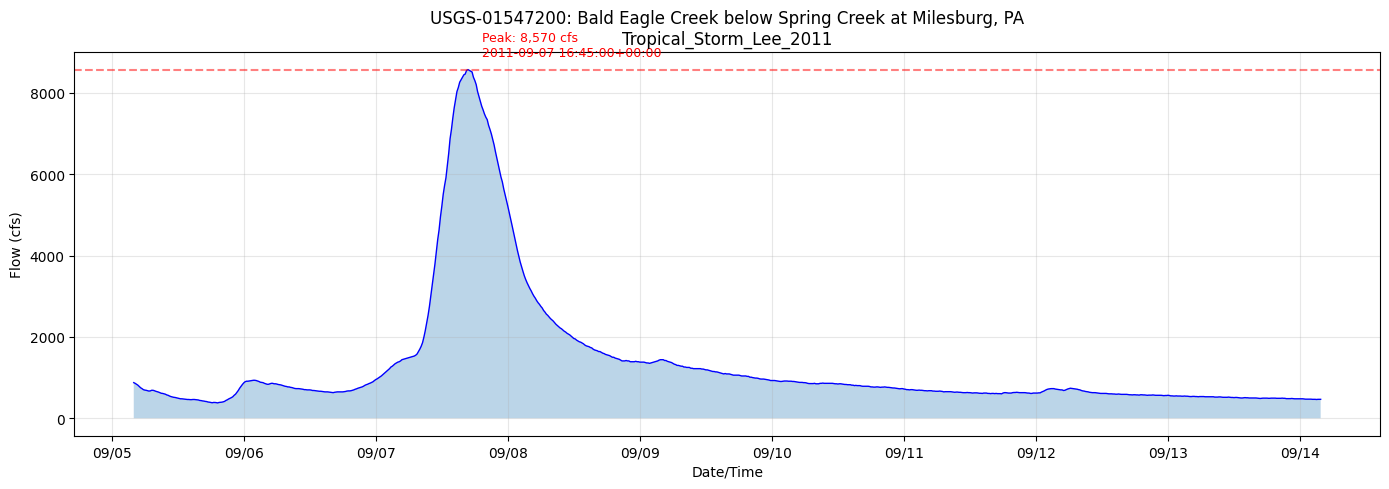

In [18]:
# Plot the upstream flow hydrograph
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(upstream_flow['datetime'], upstream_flow['value'], 'b-', linewidth=1)
ax.fill_between(upstream_flow['datetime'], upstream_flow['value'], alpha=0.3)

# Find and mark peak
peak_idx = upstream_flow['value'].idxmax()
peak_flow = upstream_flow.loc[peak_idx, 'value']
peak_time = upstream_flow.loc[peak_idx, 'datetime']
ax.axhline(y=peak_flow, color='r', linestyle='--', alpha=0.5)
ax.annotate(f'Peak: {peak_flow:,.0f} cfs\n{peak_time}', 
            xy=(peak_time, peak_flow),
            xytext=(10, 10), textcoords='offset points',
            fontsize=9, color='red')

ax.set_xlabel('Date/Time')
ax.set_ylabel('Flow (cfs)')
ax.set_title(f'USGS-{upstream_site}: {target_gauges["upstream"]["name"]}\n{event_name}')
ax.grid(True, alpha=0.3)

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.show()

In [19]:
# Now retrieve data from the downstream gauge for validation
downstream_site = target_gauges['downstream']['site_id']

# Try instantaneous first, fall back to daily
downstream_flow_df, downstream_metadata = nwis.get_iv(
    sites=downstream_site,
    parameterCd='00060',
    start=event_start.strftime('%Y-%m-%d'),
    end=event_end.strftime('%Y-%m-%d')
)

if len(downstream_flow_df) == 0:
    print("No instantaneous data for downstream gauge. Trying daily values...")
    downstream_flow_df, downstream_metadata = nwis.get_dv(
        sites=downstream_site,
        parameterCd='00060',
        start=event_start.strftime('%Y-%m-%d'),
        end=event_end.strftime('%Y-%m-%d')
    )
    ds_data_type = "daily"
else:
    ds_data_type = "instantaneous"

print(f"Retrieved {len(downstream_flow_df)} {ds_data_type} observations from downstream gauge")

if not downstream_flow_df.empty:
    flow_col_ds = [c for c in downstream_flow_df.columns if '00060' in c][0]
    
    downstream_flow = pd.DataFrame({
        'datetime': downstream_flow_df.index,
        'value': downstream_flow_df[flow_col_ds].values
    }).reset_index(drop=True)
    downstream_flow = downstream_flow.dropna(subset=['value'])
    
    print(f"Clean flow data: {len(downstream_flow)} records")
    print(f"Peak flow: {downstream_flow['value'].max():.0f} cfs")
else:
    print("No downstream flow data available for this period")
    downstream_flow = pd.DataFrame(columns=['datetime', 'value'])

No instantaneous data for downstream gauge. Trying daily values...
Retrieved 0 daily observations from downstream gauge
No downstream flow data available for this period


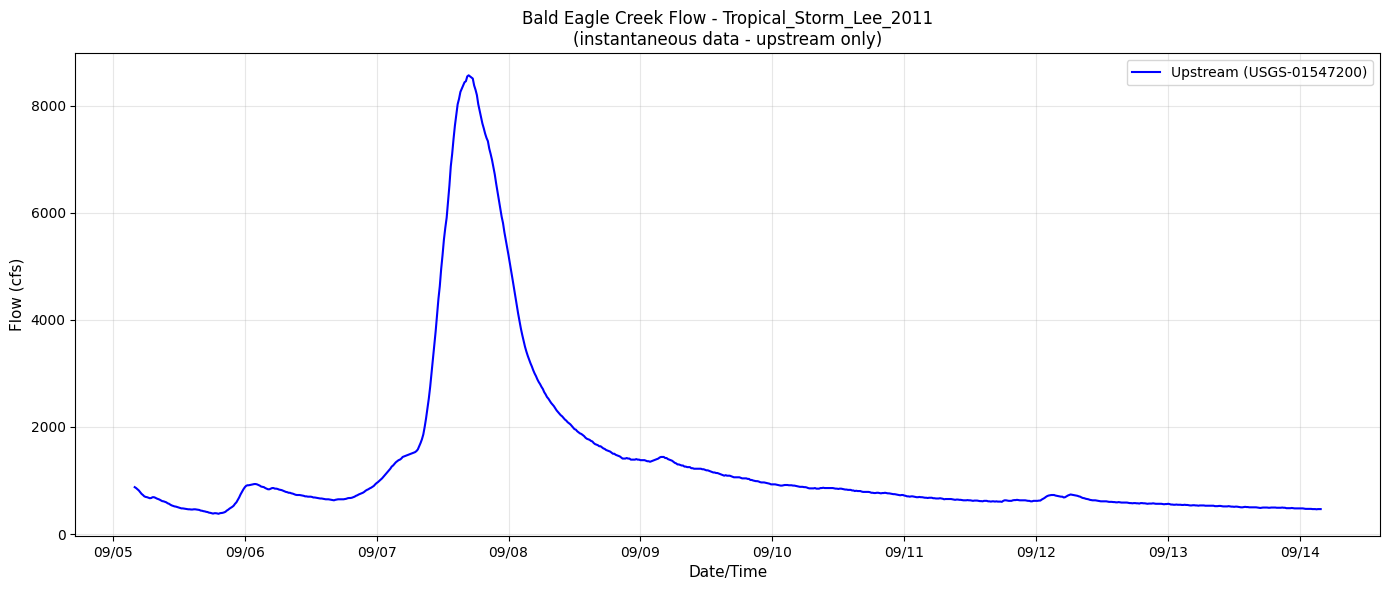

In [20]:
# Plot both gauges for comparison (if data available)
if not upstream_flow.empty and not downstream_flow.empty:
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.plot(upstream_flow['datetime'], upstream_flow['value'], 'b-o' if data_type == 'daily' else 'b-', 
            linewidth=1.5, markersize=6, label=f'Upstream (USGS-{upstream_site})')
    ax.plot(downstream_flow['datetime'], downstream_flow['value'], 'r-o' if ds_data_type == 'daily' else 'r-', 
            linewidth=1.5, markersize=6, label=f'Downstream (USGS-{downstream_site})')

    ax.set_xlabel('Date/Time', fontsize=11)
    ax.set_ylabel('Flow (cfs)', fontsize=11)
    ax.set_title(f'Bald Eagle Creek Flow - {event_name}\n({data_type} data)', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
elif not upstream_flow.empty:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(upstream_flow['datetime'], upstream_flow['value'], 'b-o' if data_type == 'daily' else 'b-', 
            linewidth=1.5, markersize=6, label=f'Upstream (USGS-{upstream_site})')
    ax.set_xlabel('Date/Time', fontsize=11)
    ax.set_ylabel('Flow (cfs)', fontsize=11)
    ax.set_title(f'Bald Eagle Creek Flow - {event_name}\n({data_type} data - upstream only)', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.tight_layout()
    plt.show()
else:
    print("No flow data available for plotting")

## 5. Retrieve Stage Data

Stage (gage height) data is useful for setting initial water surface elevations.

In [21]:
# Retrieve stage data from upstream gauge
# Try instantaneous first, fall back to daily
upstream_stage_df, stage_metadata = nwis.get_iv(
    sites=upstream_site,
    parameterCd='00065',  # Gage height
    start=event_start.strftime('%Y-%m-%d'),
    end=event_end.strftime('%Y-%m-%d')
)

if len(upstream_stage_df) == 0:
    print("No instantaneous stage data. Trying daily values...")
    upstream_stage_df, stage_metadata = nwis.get_dv(
        sites=upstream_site,
        parameterCd='00065',
        start=event_start.strftime('%Y-%m-%d'),
        end=event_end.strftime('%Y-%m-%d')
    )
    stage_data_type = "daily"
else:
    stage_data_type = "instantaneous"

print(f"Retrieved {len(upstream_stage_df)} {stage_data_type} stage observations")

if not upstream_stage_df.empty:
    stage_col = [c for c in upstream_stage_df.columns if '00065' in c][0]
    
    upstream_stage = pd.DataFrame({
        'datetime': upstream_stage_df.index,
        'value': upstream_stage_df[stage_col].values
    }).reset_index(drop=True)
    upstream_stage = upstream_stage.dropna(subset=['value'])
    
    print(f"Clean stage data: {len(upstream_stage)} records")
    print(f"Stage range: {upstream_stage['value'].min():.2f} to {upstream_stage['value'].max():.2f} ft")
else:
    print("No stage data available")
    upstream_stage = pd.DataFrame(columns=['datetime', 'value'])

Retrieved 864 instantaneous stage observations
Clean stage data: 864 records
Stage range: 0.48 to 8.07 ft


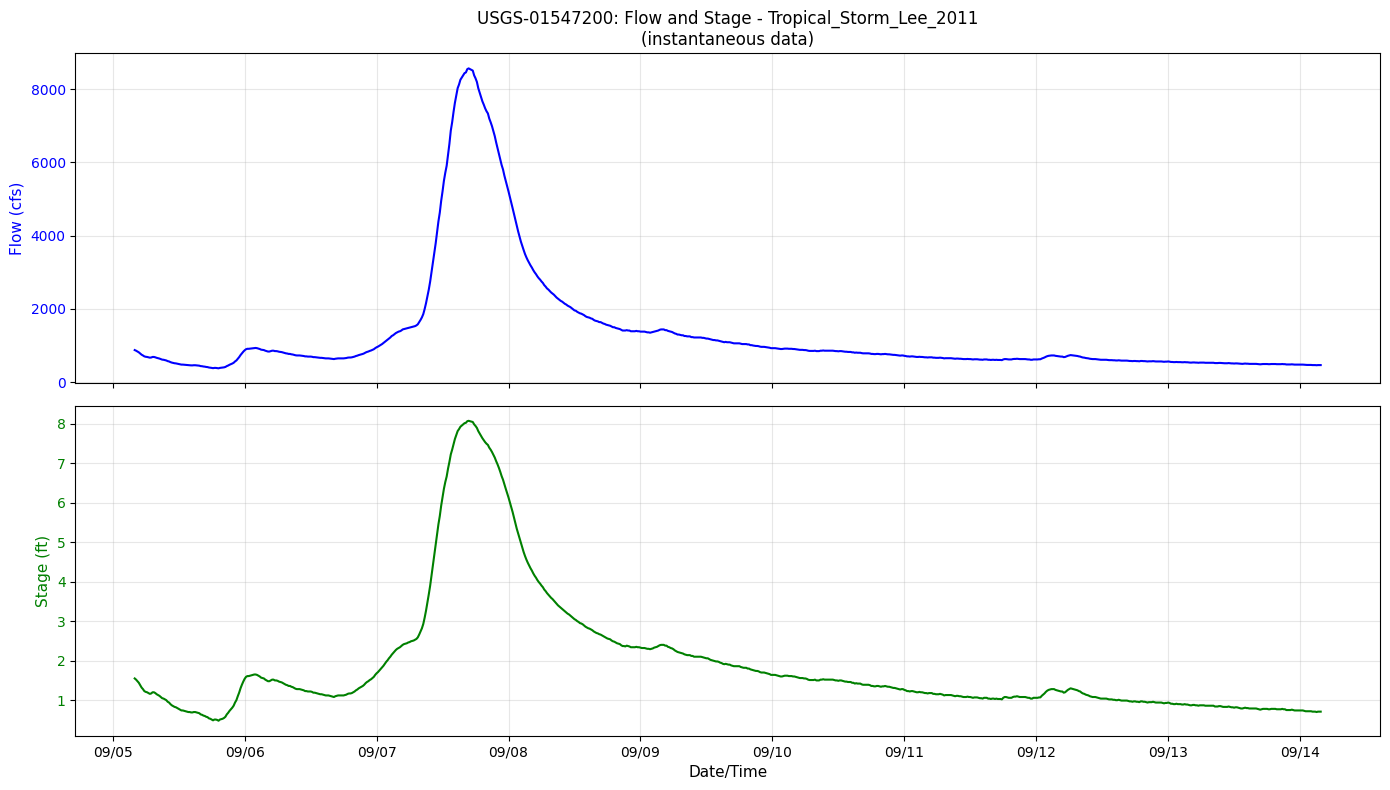

In [22]:
# Plot flow and stage together (if both available)
if not upstream_flow.empty and not upstream_stage.empty:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Flow plot
    marker = 'o' if data_type == 'daily' else ''
    ax1.plot(upstream_flow['datetime'], upstream_flow['value'], f'b-{marker}', linewidth=1.5, markersize=6)
    ax1.set_ylabel('Flow (cfs)', fontsize=11, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f'USGS-{upstream_site}: Flow and Stage - {event_name}\n({data_type} data)', fontsize=12)

    # Stage plot
    stage_marker = 'o' if stage_data_type == 'daily' else ''
    ax2.plot(upstream_stage['datetime'], upstream_stage['value'], f'g-{stage_marker}', linewidth=1.5, markersize=6)
    ax2.set_ylabel('Stage (ft)', fontsize=11, color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_xlabel('Date/Time', fontsize=11)
    ax2.grid(True, alpha=0.3)

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax2.xaxis.set_major_locator(mdates.DayLocator())

    plt.tight_layout()
    plt.show()
elif not upstream_flow.empty:
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(upstream_flow['datetime'], upstream_flow['value'], 'b-o' if data_type == 'daily' else 'b-', linewidth=1.5)
    ax.set_ylabel('Flow (cfs)', fontsize=11)
    ax.set_xlabel('Date/Time', fontsize=11)
    ax.set_title(f'USGS-{upstream_site}: Flow - {event_name} (stage not available)', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting")

## 6. Initial Conditions from USGS Data

Now we'll use the USGS gauge data to set initial conditions for a HEC-RAS simulation.

In [23]:
# Define simulation start time (when we want initial conditions)
simulation_start = datetime(2011, 9, 6, 0, 0, 0)  # Start at midnight on Sept 6

print(f"Simulation start time: {simulation_start}")

Simulation start time: 2011-09-06 00:00:00


In [24]:
# Find the flow value closest to simulation start
if not upstream_flow.empty:
    # Convert simulation_start to timezone-aware if needed
    upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'])

    # Make simulation_start timezone-aware (UTC) to match USGS data
    sim_start_utc = pd.Timestamp(simulation_start, tz='UTC')

    # Calculate time differences
    time_diffs = abs(upstream_flow['datetime'] - sim_start_utc)
    nearest_idx = time_diffs.idxmin()

    initial_flow = upstream_flow.loc[nearest_idx, 'value']
    initial_time = upstream_flow.loc[nearest_idx, 'datetime']

    print(f"Initial condition for upstream gauge:")
    print(f"  Target time: {simulation_start}")
    print(f"  Nearest observation: {initial_time}")
    print(f"  Time offset: {time_diffs[nearest_idx]}")
    print(f"  Initial flow: {initial_flow:.0f} cfs")
else:
    print("No flow data available to determine initial conditions")
    initial_flow = None

Initial condition for upstream gauge:
  Target time: 2011-09-06 00:00:00
  Nearest observation: 2011-09-06 00:00:00+00:00
  Time offset: 0 days 00:00:00
  Initial flow: 870 cfs


In [25]:
# Also get initial stage
if not upstream_stage.empty:
    upstream_stage['datetime'] = pd.to_datetime(upstream_stage['datetime'])

    stage_diffs = abs(upstream_stage['datetime'] - sim_start_utc)
    nearest_stage_idx = stage_diffs.idxmin()

    initial_stage = upstream_stage.loc[nearest_stage_idx, 'value']
    initial_stage_time = upstream_stage.loc[nearest_stage_idx, 'datetime']

    print(f"Initial stage: {initial_stage:.2f} ft at {initial_stage_time}")
else:
    print("No stage data available for initial conditions")
    initial_stage = None

Initial stage: 1.54 ft at 2011-09-06 00:00:00+00:00


### 6.1 Parse Existing Initial Conditions

Let's look at the existing initial conditions in the model's unsteady flow file.

In [26]:
# Switch to the Multi2D project which has more IC examples
multi_2d_project = RasPrj()
init_ras_project(bald_eagle_2d_path, RAS_VERSION, ras_object=multi_2d_project)

print(f"Project: {multi_2d_project.project_name}")
print(f"Unsteady files: {len(multi_2d_project.unsteady_df)}")

2025-12-29 06:54:49 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\BaldEagleDamBrk.rasmap


Project: BaldEagleDamBrk
Unsteady files: 10


In [27]:
# List available unsteady files
multi_2d_project.unsteady_df[['unsteady_number', 'Flow Title']]

,unsteady_number,Flow Title
0,07,PMF with Multi 2D Areas
1,08,PMF for Upstream 2D
2,09,Upstream 2D
3,10,1972 Flood Event - 2D to 2D Run
4,11,1972 Flood Event - SA to 2D Run
5,12,PMF for 1D - 2D
6,13,Single 2D Area
7,01,1972 Flood Event - 2D Leve Structure
8,02,Single 2D Area with Bridges
9,03,Gridded Precipitation


In [28]:
# Parse initial conditions from an unsteady file
from ras_commander.usgs import InitialConditions

# Find an unsteady file to parse (u07 has IC examples based on the plan doc)
unsteady_file = bald_eagle_2d_path / "BaldEagleDamBrk.u07"

if unsteady_file.exists():
    ic_df = InitialConditions.parse_initial_conditions(unsteady_file)
    print(f"Found {len(ic_df)} initial conditions in {unsteady_file.name}")
    display(ic_df)
else:
    print(f"Unsteady file not found: {unsteady_file}")
    # List available files
    print("Available unsteady files:")
    for uf in bald_eagle_2d_path.glob("*.u*"):
        if uf.suffix.startswith('.u') and not uf.suffix.endswith('.hdf'):
            print(f"  {uf.name}")

2025-12-29 06:54:49 - ras_commander.usgs.initial_conditions - INFO - Parsed 7 initial condition entries from BaldEagleDamBrk.u07


Found 7 initial conditions in BaldEagleDamBrk.u07


,type,river,reach,station,value,area_name
0,flow,Bald Eagle Cr.,Lock Haven,137520.0,730.0,None
1,flow,Bald Eagle Cr.,Lock Haven,81914.0,1000.0,None
2,flow,Bald Eagle Cr.,Lock Haven,-897.0,6000.0,None
3,storage,None,None,NaN,559.7,193
4,storage,None,None,NaN,615.6,195
5,storage,None,None,NaN,631.0,255
6,rrr,Bald Eagle Cr.,Lock Haven,81914.0,657.0,None


In [29]:
# Try parsing from u01 which is more common
unsteady_file_u01 = bald_eagle_2d_path / "BaldEagleDamBrk.u01"

if unsteady_file_u01.exists():
    ic_df = InitialConditions.parse_initial_conditions(unsteady_file_u01)
    print(f"Found {len(ic_df)} initial conditions in {unsteady_file_u01.name}")
    if not ic_df.empty:
        display(ic_df)
    else:
        print("No initial conditions defined in this file.")

2025-12-29 06:54:49 - ras_commander.usgs.initial_conditions - INFO - Parsed 1 initial condition entries from BaldEagleDamBrk.u01


Found 1 initial conditions in BaldEagleDamBrk.u01


,type,river,reach,station,value,area_name
0,storage,None,None,None,650.0,Reservoir Pool


### 6.2 Create Initial Condition Lines from USGS Data

Now we'll create IC lines using the USGS data we retrieved.

In [30]:
# Define the gauge-to-model mapping for this project
# Based on example_notebook_plan.md
if initial_flow is not None:
    gauge_model_mapping = [
        {
            'gauge_id': 'USGS-01547200',
            'gauge_name': 'Milesburg',
            'river': 'Bald Eagle Cr.',
            'reach': 'Lock Haven',
            'station': 137520,
            'usgs_flow': initial_flow,
            'ic_type': 'flow'
        }
    ]

    print("Gauge-to-Model Mapping:")
    for mapping in gauge_model_mapping:
        print(f"  {mapping['gauge_id']} ({mapping['gauge_name']})")
        print(f"    -> {mapping['river']}/{mapping['reach']}/Station {mapping['station']}")
        print(f"    Flow: {mapping['usgs_flow']:.0f} cfs")
else:
    gauge_model_mapping = []
    print("Cannot create gauge mapping - no initial flow data available")

Gauge-to-Model Mapping:
  USGS-01547200 (Milesburg)
    -> Bald Eagle Cr./Lock Haven/Station 137520
    Flow: 870 cfs


In [31]:
# Create IC line using the InitialConditions class
if gauge_model_mapping:
    for mapping in gauge_model_mapping:
        ic_line = InitialConditions.create_ic_line(
            ic_type=mapping['ic_type'],
            river=mapping['river'],
            reach=mapping['reach'],
            station=mapping['station'],
            value=mapping['usgs_flow']
        )
        print(f"Generated IC line:")
        print(f"  {ic_line}")
else:
    print("No gauge mapping available to create IC lines")

Generated IC line:
  Initial Flow Loc=Bald Eagle Cr.   ,Lock Haven       ,137520  ,870.0


## 7. Summary and Data Cache

Let's summarize what we've retrieved and cache the data for future use.

In [34]:
# Create gauge_data directory
gauge_data_dir = bald_eagle_2d_path / 'gauge_data'
gauge_data_dir.mkdir(exist_ok=True)

raw_dir = gauge_data_dir / 'raw'
raw_dir.mkdir(exist_ok=True)

print(f"Gauge data directory: {gauge_data_dir}")

Gauge data directory: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\gauge_data


In [35]:
# Save the retrieved data (if available)
start_str = event_start.strftime('%Y%m%d')
end_str = event_end.strftime('%Y%m%d')

saved_files = []

# Save upstream flow
if not upstream_flow.empty:
    upstream_flow_file = raw_dir / f"USGS-{upstream_site}_{start_str}_{end_str}_flow.csv"
    upstream_flow.to_csv(upstream_flow_file, index=False)
    print(f"Saved: {upstream_flow_file.name}")
    saved_files.append(upstream_flow_file)

# Save upstream stage
if not upstream_stage.empty:
    upstream_stage_file = raw_dir / f"USGS-{upstream_site}_{start_str}_{end_str}_stage.csv"
    upstream_stage.to_csv(upstream_stage_file, index=False)
    print(f"Saved: {upstream_stage_file.name}")
    saved_files.append(upstream_stage_file)

# Save downstream flow
if not downstream_flow.empty:
    downstream_flow_file = raw_dir / f"USGS-{downstream_site}_{start_str}_{end_str}_flow.csv"
    downstream_flow.to_csv(downstream_flow_file, index=False)
    print(f"Saved: {downstream_flow_file.name}")
    saved_files.append(downstream_flow_file)

if not saved_files:
    print("No data files were saved")

Saved: USGS-01547200_20110905_20110913_flow.csv
Saved: USGS-01547200_20110905_20110913_stage.csv


In [36]:
# Summary
print("=" * 70)
print("USGS GAUGE DATA INTEGRATION - SUMMARY")
print("=" * 70)
print(f"\nEvent: {event_name}")
print(f"Period: {event_start} to {event_end}")
print(f"\nProject: {ras.project_name}")
print(f"Location: {bald_eagle_2d_path}")
print(f"\nUSGS Gauges Used:")

if not upstream_flow.empty:
    stage_count = len(upstream_stage) if not upstream_stage.empty else 0
    print(f"  Upstream:   USGS-{upstream_site} ({len(upstream_flow)} flow obs, {stage_count} stage obs) [{data_type}]")
    print(f"  Peak Flow:  {upstream_flow['value'].max():,.0f} cfs")
else:
    print(f"  Upstream:   USGS-{upstream_site} - No data available")

if not downstream_flow.empty:
    print(f"  Downstream: USGS-{downstream_site} ({len(downstream_flow)} flow obs) [{ds_data_type}]")
    print(f"  Peak Flow:  {downstream_flow['value'].max():,.0f} cfs")
else:
    print(f"  Downstream: USGS-{downstream_site} - No data available")

if initial_flow is not None:
    print(f"\nInitial Condition at {simulation_start}:")
    print(f"  Flow:  {initial_flow:.0f} cfs")
    if initial_stage is not None:
        print(f"  Stage: {initial_stage:.2f} ft")

print(f"\nData saved to: {gauge_data_dir}")
print("=" * 70)

USGS GAUGE DATA INTEGRATION - SUMMARY

Event: Tropical_Storm_Lee_2011
Period: 2011-09-05 00:00:00 to 2011-09-13 00:00:00

Project: BaldEagleDamBrk
Location: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911

USGS Gauges Used:
  Upstream:   USGS-01547200 (864 flow obs, 864 stage obs) [instantaneous]
  Peak Flow:  8,570 cfs
  Downstream: USGS-01548010 - No data available

Initial Condition at 2011-09-06 00:00:00:
  Flow:  870 cfs
  Stage: 1.54 ft

Data saved to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\gauge_data


## 8. View Plan Simulation Dates

Let's check the existing plan simulation dates to understand how to align USGS data with the simulation window.

In [39]:
# Switch back to 1D project
init_ras_project(bald_eagle_2d_path, RAS_VERSION)

# View plan simulation dates
print("Plan Simulation Dates:")
ras.plan_df[['plan_number', 'Plan Title', 'Simulation Date', 'Computation Interval']]

2025-12-29 06:55:18 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\BaldEagleDamBrk.rasmap


Plan Simulation Dates:


,plan_number,Plan Title,Simulation Date,Computation Interval
0,13,PMF with Multi 2D Areas,"01JAN1999,1200,04JAN1999,1200",30SEC
1,15,1d-2D Dambreak Refined Grid,"01JAN1999,1200,04JAN1999,1200",20SEC
2,17,2D to 1D No Dam,"01JAN1999,1200,06JAN1999,1200",1MIN
3,18,2D to 2D Run,"01JAN1999,1200,04JAN1999,1200",20SEC
4,19,SA to 2D Dam Break Run,"01JAN1999,1200,04JAN1999,1200",20SEC
5,03,Single 2D Area - Internal Dam Structure,"01JAN1999,1200,04JAN1999,1200",30SEC
6,04,SA to 2D Area Conn - 2D Levee Structure,"01JAN1999,1200,04JAN1999,1200",20SEC
7,02,SA to Detailed 2D Breach,"01JAN1999,1200,04JAN1999,1200",10SEC
8,01,SA to Detailed 2D Breach FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC
9,05,Single 2D area with Bridges FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC


In [40]:
# Parse the simulation date from the existing plan
sim_date_str = ras.plan_df.iloc[0]['Simulation Date']
print(f"Current simulation date string: {sim_date_str}")

# HEC-RAS format: DDMONYYYY,HHMM,DDMONYYYY,HHMM
# Example: 18FEB1999,0000,24FEB1999,0500

Current simulation date string: 01JAN1999,1200,04JAN1999,1200


In [41]:
# Check boundary condition intervals
print("\nBoundary Condition Intervals:")
ras.boundaries_df[['river_reach_name', 'bc_type', 'Interval']]


Boundary Condition Intervals:


,river_reach_name,bc_type,Interval
0,Bald Eagle Cr.,Flow Hydrograph,1HOUR
1,Bald Eagle Cr.,Gate Opening,NaN
2,Bald Eagle Cr.,Lateral Inflow Hydrograph,1HOUR
3,Bald Eagle Cr.,Lateral Inflow Hydrograph,1HOUR
4,Bald Eagle Cr.,Uniform Lateral Inflow Hydrograph,1HOUR
5,Bald Eagle Cr.,Uniform Lateral Inflow Hydrograph,1HOUR
6,Bald Eagle Cr.,Lateral Inflow Hydrograph,1HOUR
7,Bald Eagle Cr.,Lateral Inflow Hydrograph,1HOUR
8,Bald Eagle Cr.,Uniform Lateral Inflow Hydrograph,1HOUR
9,Bald Eagle Cr.,Normal Depth,NaN


In [42]:
# Calculate how many values we need for our event period at different intervals
event_duration = event_end - event_start
duration_hours = event_duration.total_seconds() / 3600

intervals = {
    '15MIN': 15/60,
    '30MIN': 30/60,
    '1HOUR': 1,
    '2HOUR': 2,
    '6HOUR': 6
}

print(f"Event duration: {duration_hours:.0f} hours ({event_duration.days} days)")
print(f"\nValues needed for each interval:")
for interval, hours in intervals.items():
    num_values = int(duration_hours / hours) + 1
    print(f"  {interval}: {num_values} values")

Event duration: 192 hours (8 days)

Values needed for each interval:
  15MIN: 769 values
  30MIN: 385 values
  1HOUR: 193 values
  2HOUR: 97 values
  6HOUR: 33 values


In [43]:
# Check USGS data interval
time_diffs = upstream_flow['datetime'].diff().dropna()
median_interval = time_diffs.median()
print(f"USGS data median interval: {median_interval}")
print(f"\nWe have {len(upstream_flow)} observations over {duration_hours:.0f} hours")
print(f"This is approximately {len(upstream_flow) / duration_hours:.1f} observations per hour")

USGS data median interval: 0 days 00:15:00

We have 864 observations over 192 hours
This is approximately 4.5 observations per hour


## Next Steps

In the next phase, we will:

1. **Resample USGS data** to match HEC-RAS boundary condition interval (1HOUR)
2. **Generate fixed-width flow hydrograph table** for the unsteady file
3. **Update the boundary condition** in the .u## file
4. **Update plan simulation dates** to match the historic event
5. **Run the simulation** using RasCmdr.compute_plan()
6. **Validate results** against downstream USGS gauge

## 9. Professional QAQC Visualizations

The following figures are designed for engineering QAQC review and inclusion in engineering reports. They include:

- **Data Quality Dashboard**: Comprehensive assessment of data completeness, gaps, and temporal consistency
- **Event Hydrograph**: Publication-quality hydrograph with dual axes and professional annotations
- **Stage-Discharge Rating Curve**: Rating curve analysis with power law fit
- **Summary Statistics Dashboard**: Single-page comprehensive data summary for reports

In [44]:
# =============================================================================
# PROFESSIONAL QAQC VISUALIZATION SETUP
# =============================================================================

import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from scipy import stats
from scipy.optimize import curve_fit

# Configure matplotlib for publication-quality figures
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 150,
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# Define consistent color palette for QAQC figures
COLORS = {
    'flow': '#1f77b4',        # Blue
    'stage': '#2ca02c',       # Green  
    'upstream': '#1f77b4',    # Blue
    'downstream': '#d62728',  # Red
    'peak': '#d62728',        # Red
    'warning': '#ff7f0e',     # Orange
    'good': '#2ca02c',        # Green
    'bad': '#d62728',         # Red
    'neutral': '#7f7f7f',     # Gray
    'gap': '#ffcccc',         # Light red for gaps
}

def create_stats_box(ax, text, loc='upper left', fontsize=9):
    """Create a standardized statistics annotation box."""
    props = dict(boxstyle='round,pad=0.5', facecolor='white', 
                 alpha=0.9, edgecolor='gray', linewidth=0.5)
    
    positions = {
        'upper left': (0.02, 0.98, 'top', 'left'),
        'upper right': (0.98, 0.98, 'top', 'right'),
        'lower left': (0.02, 0.02, 'bottom', 'left'),
        'lower right': (0.98, 0.02, 'bottom', 'right'),
    }
    x, y, va, ha = positions.get(loc, positions['upper left'])
    
    ax.text(x, y, text, transform=ax.transAxes, fontsize=fontsize, 
            fontfamily='monospace', verticalalignment=va, 
            horizontalalignment=ha, bbox=props)

def format_datetime_axis(ax, date_format='%m/%d', rotation=45):
    """Apply consistent datetime formatting to x-axis."""
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=rotation, ha='right')

# Create plots directory
plots_dir = gauge_data_dir / 'plots'
plots_dir.mkdir(exist_ok=True)

print("QAQC Visualization configuration loaded")
print(f"  - Figure DPI: {plt.rcParams['savefig.dpi']}")
print(f"  - Color palette: {len(COLORS)} colors defined")
print(f"  - Output directory: {plots_dir}")

QAQC Visualization configuration loaded
  - Figure DPI: 150.0
  - Color palette: 10 colors defined
  - Output directory: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\gauge_data\plots


### 9.1 Data Quality Dashboard

A 4-panel dashboard for comprehensive data quality assessment:
- Time series with gap highlighting
- Data completeness by parameter
- Distribution of observation intervals
- Data presence timeline

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_298804\2916896244.py:109: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(upstream_flow['datetime'].min(),


Saved: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\gauge_data\plots\Tropical_Storm_Lee_2011_data_quality_dashboard.png


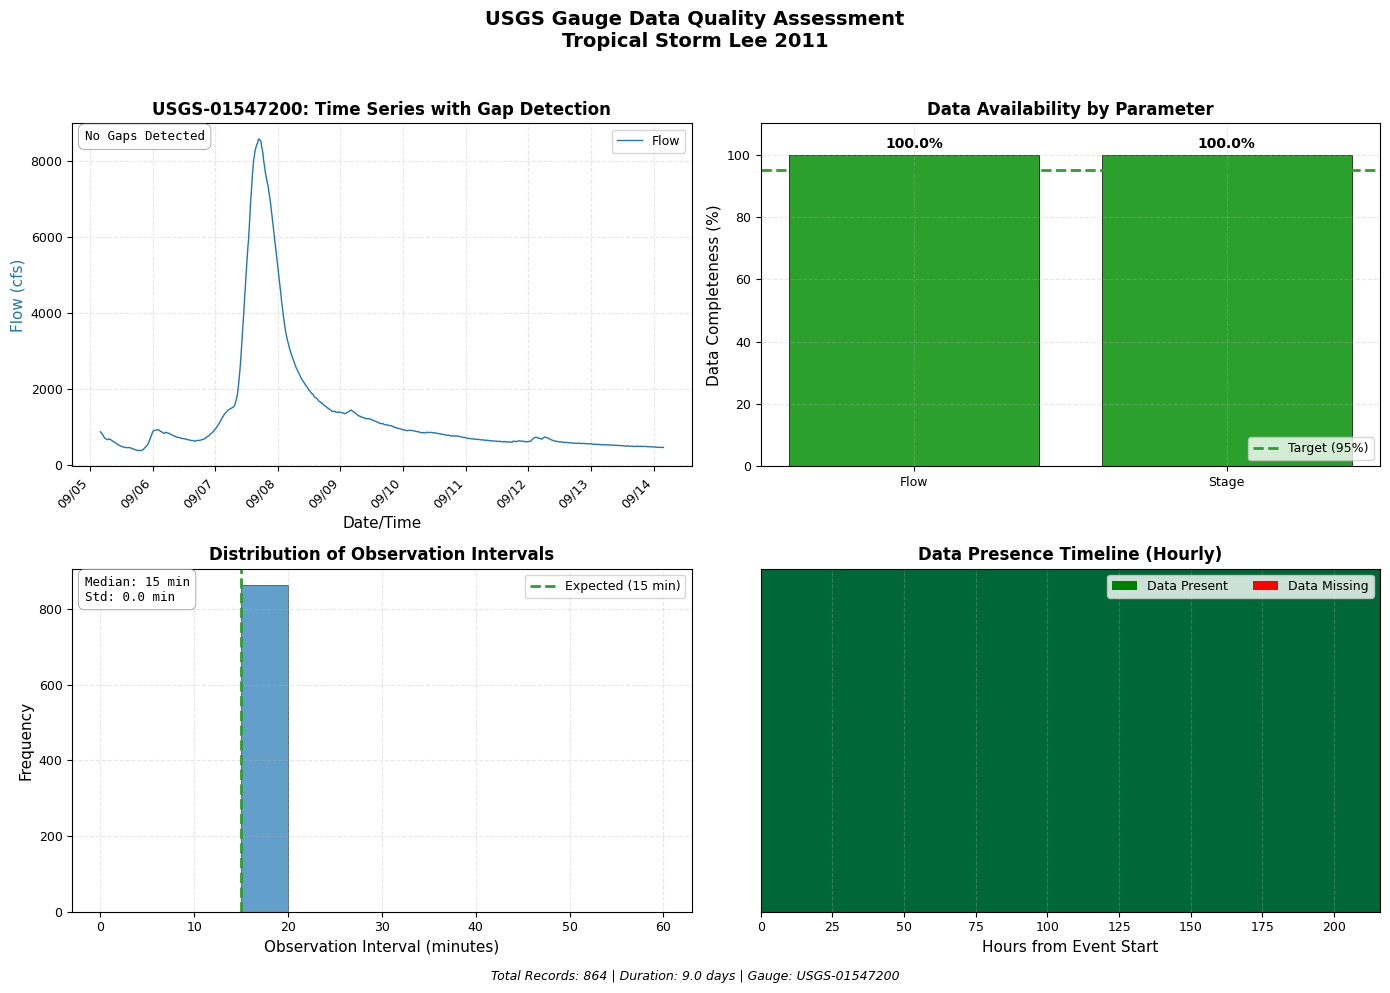

In [45]:
# =============================================================================
# FIGURE A1: DATA QUALITY DASHBOARD (4-PANEL)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'USGS Gauge Data Quality Assessment\n{event_name.replace("_", " ")}', 
             fontsize=14, fontweight='bold', y=0.98)

# ==========================================================================
# Panel 1: Time Series with Gap Highlighting (Top Left)
# ==========================================================================
ax1 = axes[0, 0]

ax1.plot(upstream_flow['datetime'], upstream_flow['value'], 
         color=COLORS['flow'], linewidth=1, label='Flow')

# Detect and highlight gaps (> 30 minutes for 15-min data)
time_diffs = upstream_flow['datetime'].diff()
gap_threshold = pd.Timedelta(minutes=45)
gaps = upstream_flow[time_diffs > gap_threshold].copy()
gap_count = len(gaps)

for idx in gaps.index:
    gap_start = upstream_flow.loc[idx - 1, 'datetime'] if idx > 0 else upstream_flow['datetime'].iloc[0]
    gap_end = upstream_flow.loc[idx, 'datetime']
    ax1.axvspan(gap_start, gap_end, alpha=0.3, color=COLORS['gap'], 
                label='Data Gap' if idx == gaps.index[0] else '')

ax1.set_xlabel('Date/Time')
ax1.set_ylabel('Flow (cfs)', color=COLORS['flow'])
ax1.set_title(f'USGS-{upstream_site}: Time Series with Gap Detection', fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
format_datetime_axis(ax1)

# Add gap statistics
if gap_count > 0:
    max_gap = time_diffs.max()
    gap_text = f"Gaps: {gap_count}\nMax Gap: {max_gap}"
else:
    gap_text = "No Gaps Detected"
create_stats_box(ax1, gap_text, loc='upper left')

# ==========================================================================
# Panel 2: Data Completeness Bar Chart (Top Right)
# ==========================================================================
ax2 = axes[0, 1]

event_duration = (upstream_flow['datetime'].max() - upstream_flow['datetime'].min())
expected_records = int(event_duration.total_seconds() / (15 * 60)) + 1

completeness = {
    'Flow': len(upstream_flow) / expected_records * 100 if expected_records > 0 else 0,
    'Stage': len(upstream_stage) / expected_records * 100 if expected_records > 0 else 0
}

bars = ax2.bar(completeness.keys(), completeness.values(), 
               color=[COLORS['flow'], COLORS['stage']], edgecolor='black', linewidth=0.5)

ax2.axhline(y=95, color=COLORS['good'], linestyle='--', linewidth=2, label='Target (95%)')

for bar, (param, pct) in zip(bars, completeness.items()):
    if pct >= 95:
        bar.set_facecolor(COLORS['good'])
    elif pct >= 80:
        bar.set_facecolor(COLORS['warning'])
    else:
        bar.set_facecolor(COLORS['bad'])
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

ax2.set_ylabel('Data Completeness (%)')
ax2.set_title('Data Availability by Parameter', fontweight='bold')
ax2.set_ylim(0, 110)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3, axis='y')

# ==========================================================================
# Panel 3: Observation Interval Histogram (Bottom Left)
# ==========================================================================
ax3 = axes[1, 0]

intervals_min = time_diffs.dt.total_seconds().dropna() / 60
bins = np.arange(0, max(61, intervals_min.max() + 5), 5)
counts, bins_out, patches = ax3.hist(intervals_min, bins=bins, 
                                      color=COLORS['flow'], edgecolor='black',
                                      alpha=0.7, linewidth=0.5)

ax3.axvline(x=15, color=COLORS['good'], linestyle='--', linewidth=2, label='Expected (15 min)')

for patch, left_edge in zip(patches, bins_out[:-1]):
    if left_edge > 20 or (left_edge > 0 and left_edge < 10):
        patch.set_facecolor(COLORS['warning'])

ax3.set_xlabel('Observation Interval (minutes)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Observation Intervals', fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3, axis='y')

interval_stats = f"Median: {intervals_min.median():.0f} min\nStd: {intervals_min.std():.1f} min"
create_stats_box(ax3, interval_stats, loc='upper left')

# ==========================================================================
# Panel 4: Data Timeline Visualization (Bottom Right)
# ==========================================================================
ax4 = axes[1, 1]

date_range = pd.date_range(upstream_flow['datetime'].min(), 
                            upstream_flow['datetime'].max(), freq='1H')

presence = []
for dt in date_range:
    has_data = any((upstream_flow['datetime'] >= dt) & 
                   (upstream_flow['datetime'] < dt + pd.Timedelta(hours=1)))
    presence.append(1 if has_data else 0)

presence_arr = np.array(presence).reshape(1, -1)
ax4.imshow(presence_arr, aspect='auto', cmap='RdYlGn', 
           extent=[0, len(presence), 0, 1], vmin=0, vmax=1)

ax4.set_yticks([])
ax4.set_xlabel('Hours from Event Start')
ax4.set_title('Data Presence Timeline (Hourly)', fontweight='bold')

legend_elements = [Patch(facecolor='green', label='Data Present'),
                   Patch(facecolor='red', label='Data Missing')]
ax4.legend(handles=legend_elements, loc='upper right', ncol=2)

plt.tight_layout(rect=[0, 0.02, 1, 0.96])

# Footer
total_records = len(upstream_flow)
duration_days = event_duration.days + event_duration.seconds / 86400
footer_text = (f"Total Records: {total_records:,} | "
               f"Duration: {duration_days:.1f} days | "
               f"Gauge: USGS-{upstream_site}")
fig.text(0.5, 0.01, footer_text, ha='center', fontsize=9, style='italic')

fig.savefig(plots_dir / f'{event_name}_data_quality_dashboard.png', 
            dpi=150, bbox_inches='tight', facecolor='white')
print(f"Saved: {plots_dir / f'{event_name}_data_quality_dashboard.png'}")
plt.show()

### 9.2 Publication-Quality Event Hydrograph

Professional hydrograph with dual axes (flow and stage), peak annotations, initial condition marker, and comprehensive event statistics.

Saved: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\gauge_data\plots\Tropical_Storm_Lee_2011_hydrograph.png


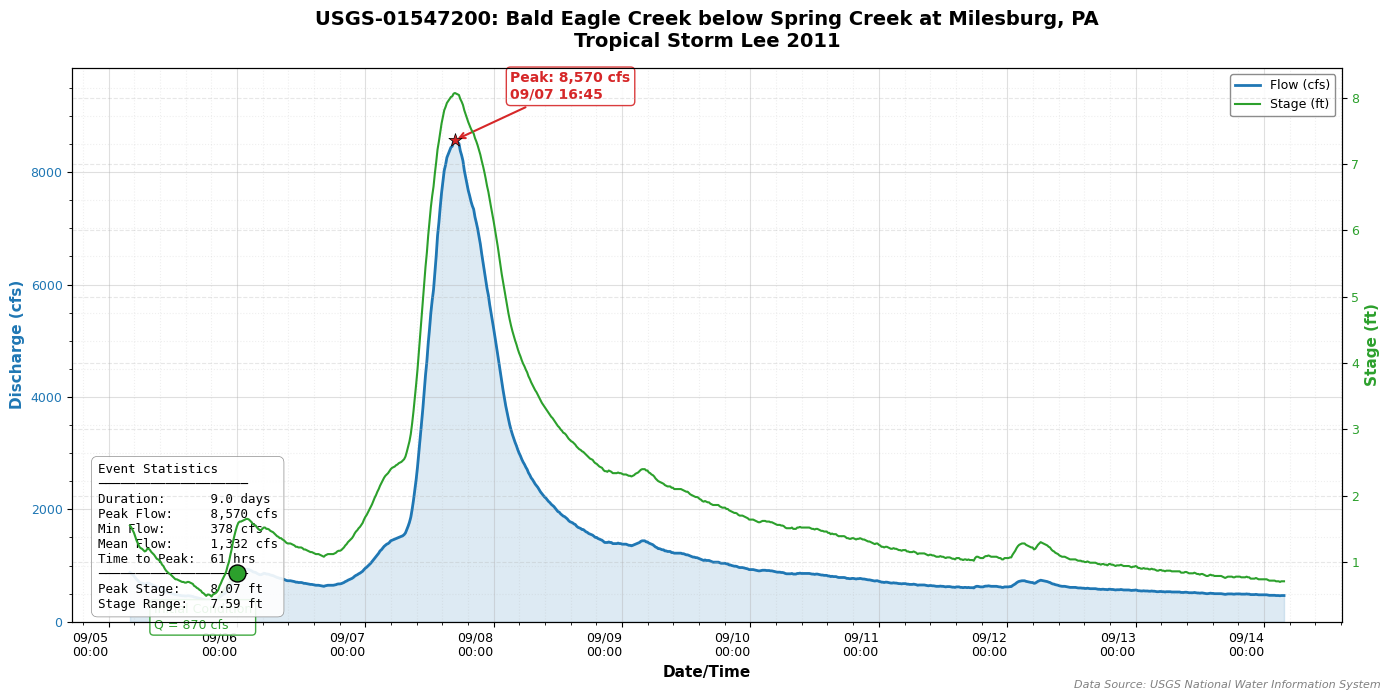

In [46]:
# =============================================================================
# FIGURE B1: PUBLICATION-QUALITY EVENT HYDROGRAPH
# =============================================================================

fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary Y-Axis: Flow
line_flow, = ax1.plot(upstream_flow['datetime'], upstream_flow['value'], 
                      color=COLORS['flow'], linewidth=2, label='Flow (cfs)')
ax1.fill_between(upstream_flow['datetime'], upstream_flow['value'], 
                 alpha=0.15, color=COLORS['flow'])

ax1.set_xlabel('Date/Time', fontsize=11, fontweight='bold')
ax1.set_ylabel('Discharge (cfs)', color=COLORS['flow'], fontsize=11, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=COLORS['flow'])

# Secondary Y-Axis: Stage
ax2 = ax1.twinx()
if not upstream_stage.empty:
    line_stage, = ax2.plot(upstream_stage['datetime'], upstream_stage['value'],
                           color=COLORS['stage'], linewidth=1.5, label='Stage (ft)')
    ax2.set_ylabel('Stage (ft)', color=COLORS['stage'], fontsize=11, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=COLORS['stage'])

# Peak Flow Annotation
peak_idx = upstream_flow['value'].idxmax()
peak_flow = upstream_flow.loc[peak_idx, 'value']
peak_time = upstream_flow.loc[peak_idx, 'datetime']

ax1.scatter([peak_time], [peak_flow], color=COLORS['peak'], s=100, 
            zorder=5, marker='*', edgecolors='black', linewidth=0.5)

ax1.annotate(
    f'Peak: {peak_flow:,.0f} cfs\n{peak_time.strftime("%m/%d %H:%M")}',
    xy=(peak_time, peak_flow),
    xytext=(40, 30),
    textcoords='offset points',
    fontsize=10, fontweight='bold', color=COLORS['peak'],
    arrowprops=dict(arrowstyle='->', color=COLORS['peak'], lw=1.5),
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
              edgecolor=COLORS['peak'], alpha=0.9)
)

# Initial Condition Point
if initial_flow is not None:
    sim_start_utc = pd.Timestamp(simulation_start, tz='UTC')
    time_diffs_ic = abs(upstream_flow['datetime'] - sim_start_utc)
    nearest_idx = time_diffs_ic.idxmin()
    ic_flow = upstream_flow.loc[nearest_idx, 'value']
    ic_time = upstream_flow.loc[nearest_idx, 'datetime']
    
    ax1.scatter([ic_time], [ic_flow], color=COLORS['good'], s=150,
                zorder=5, marker='o', edgecolors='black', linewidth=1)
    
    ax1.annotate(
        f'Initial Condition\nQ = {ic_flow:,.0f} cfs',
        xy=(ic_time, ic_flow),
        xytext=(-60, -40),
        textcoords='offset points',
        fontsize=9, color=COLORS['good'],
        arrowprops=dict(arrowstyle='->', color=COLORS['good'], lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                  edgecolor=COLORS['good'], alpha=0.9)
    )

# Calculate Event Statistics
event_start_time = upstream_flow['datetime'].min()
time_to_peak = peak_time - event_start_time
time_to_peak_hours = time_to_peak.total_seconds() / 3600
event_duration = upstream_flow['datetime'].max() - upstream_flow['datetime'].min()
duration_days = event_duration.days + event_duration.seconds / 86400
min_flow = upstream_flow['value'].min()
mean_flow = upstream_flow['value'].mean()

# Statistics Box
stats_text = (
    f"Event Statistics\n"
    f"{'─' * 20}\n"
    f"Duration:      {duration_days:.1f} days\n"
    f"Peak Flow:     {peak_flow:,.0f} cfs\n"
    f"Min Flow:      {min_flow:,.0f} cfs\n"
    f"Mean Flow:     {mean_flow:,.0f} cfs\n"
    f"Time to Peak:  {time_to_peak_hours:.0f} hrs\n"
)
if not upstream_stage.empty:
    peak_stage = upstream_stage['value'].max()
    min_stage = upstream_stage['value'].min()
    stats_text += (
        f"{'─' * 20}\n"
        f"Peak Stage:    {peak_stage:.2f} ft\n"
        f"Stage Range:   {peak_stage - min_stage:.2f} ft"
    )

create_stats_box(ax1, stats_text, loc='lower left', fontsize=9)

# Formatting
ax1.set_title(
    f'USGS-{upstream_site}: {target_gauges["upstream"]["name"]}\n{event_name.replace("_", " ")}',
    fontsize=14, fontweight='bold', pad=15
)

ax1.grid(True, which='major', alpha=0.4, linestyle='-')
ax1.grid(True, which='minor', alpha=0.2, linestyle=':')
ax1.minorticks_on()

format_datetime_axis(ax1, date_format='%m/%d\n%H:%M', rotation=0)

# Legend
lines = [line_flow]
labels = ['Flow (cfs)']
if not upstream_stage.empty:
    lines.append(line_stage)
    labels.append('Stage (ft)')
ax1.legend(lines, labels, loc='upper right', framealpha=0.9, edgecolor='gray')

ax1.set_ylim(0, peak_flow * 1.15)
plt.tight_layout()

fig.text(0.99, 0.01, f'Data Source: USGS National Water Information System',
         ha='right', fontsize=8, style='italic', color='gray')

fig.savefig(plots_dir / f'{event_name}_hydrograph.png', 
            dpi=150, bbox_inches='tight', facecolor='white')
print(f"Saved: {plots_dir / f'{event_name}_hydrograph.png'}")
plt.show()

### 9.3 Stage-Discharge Rating Curve

Rating curve analysis showing the stage-discharge relationship with power law fit and time-colored scatter points to identify hysteresis effects.

Saved: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\gauge_data\plots\Tropical_Storm_Lee_2011_rating_curve.png


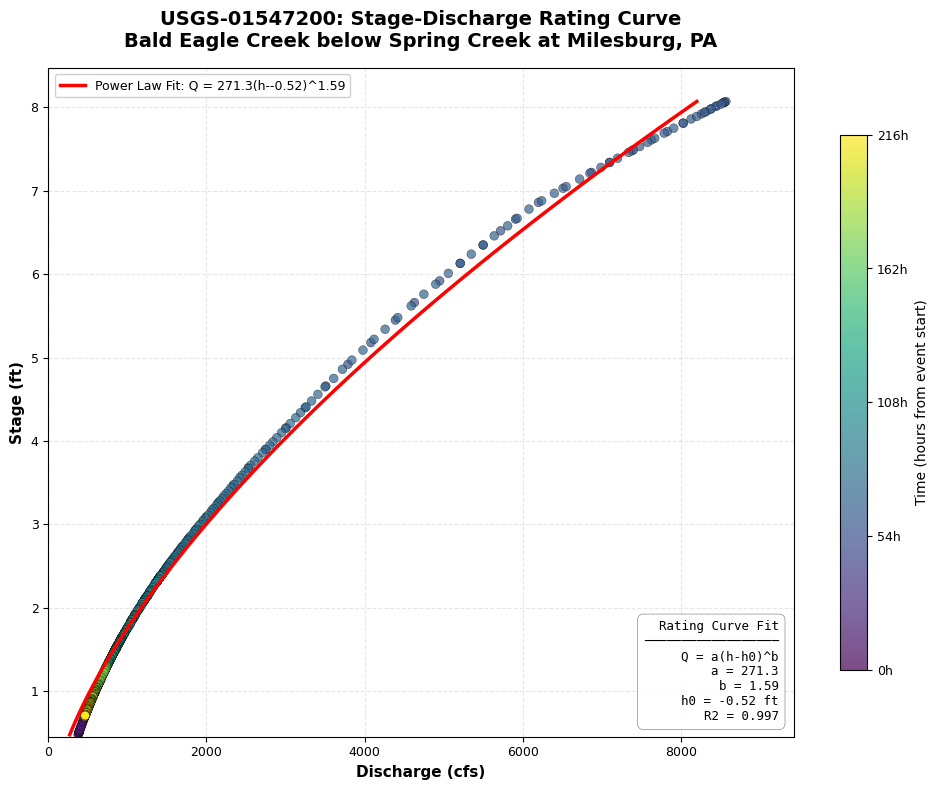

In [47]:
# =============================================================================
# FIGURE D1: STAGE-DISCHARGE RATING CURVE
# =============================================================================

if not upstream_stage.empty:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Merge flow and stage by nearest timestamp
    merged = pd.merge_asof(
        upstream_flow.sort_values('datetime'),
        upstream_stage.sort_values('datetime'),
        on='datetime',
        direction='nearest',
        tolerance=pd.Timedelta(minutes=30),
        suffixes=('_flow', '_stage')
    ).dropna()
    
    if len(merged) >= 10:
        Q = merged['value_flow'].values
        h = merged['value_stage'].values
        
        # Create time-based colors
        times_numeric = (merged['datetime'] - merged['datetime'].min()).dt.total_seconds()
        
        # Scatter Plot with Time Colormap
        scatter = ax.scatter(Q, h, c=times_numeric, cmap='viridis', 
                             s=40, alpha=0.7, edgecolors='black', linewidth=0.3)
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label('Time (hours from event start)', fontsize=10)
        max_hours = times_numeric.max() / 3600
        cbar.set_ticks(np.linspace(0, times_numeric.max(), 5))
        cbar.set_ticklabels([f'{t:.0f}h' for t in np.linspace(0, max_hours, 5)])
        
        # Power Law Fit: Q = a * (h - h0)^b
        def power_law(h, a, b, h0):
            return a * np.maximum(h - h0, 0.001) ** b
        
        try:
            h0_init = h.min() - 0.1
            popt, pcov = curve_fit(power_law, h, Q, 
                                   p0=[100, 2.0, h0_init],
                                   bounds=([0, 0.5, h.min()-1], [10000, 4.0, h.min()]),
                                   maxfev=5000)
            
            a, b, h0 = popt
            
            h_fit = np.linspace(h.min(), h.max(), 100)
            Q_fit = power_law(h_fit, a, b, h0)
            
            ax.plot(Q_fit, h_fit, 'r-', linewidth=2.5, 
                    label=f'Power Law Fit: Q = {a:.1f}(h-{h0:.2f})^{b:.2f}')
            
            # Calculate R-squared
            Q_pred = power_law(h, a, b, h0)
            ss_res = np.sum((Q - Q_pred) ** 2)
            ss_tot = np.sum((Q - np.mean(Q)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            
            fit_text = (
                f"Rating Curve Fit\n"
                f"{'─' * 18}\n"
                f"Q = a(h-h0)^b\n"
                f"a = {a:.1f}\n"
                f"b = {b:.2f}\n"
                f"h0 = {h0:.2f} ft\n"
                f"R2 = {r_squared:.3f}"
            )
            
        except Exception as e:
            print(f"Power law fit failed: {e}")
            fit_text = "Power law fit\nnot available"
        
        create_stats_box(ax, fit_text, loc='lower right', fontsize=9)
        
        ax.set_xlabel('Discharge (cfs)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Stage (ft)', fontsize=11, fontweight='bold')
        ax.set_title(f'USGS-{upstream_site}: Stage-Discharge Rating Curve\n{target_gauges["upstream"]["name"]}',
                     fontsize=14, fontweight='bold', pad=15)
        
        ax.legend(loc='upper left', framealpha=0.9)
        ax.grid(True, alpha=0.3)
        
        ax.set_xlim(0, Q.max() * 1.1)
        ax.set_ylim(h.min() * 0.95, h.max() * 1.05)
        
        plt.tight_layout()
        
        fig.savefig(plots_dir / f'{event_name}_rating_curve.png', 
                    dpi=150, bbox_inches='tight', facecolor='white')
        print(f"Saved: {plots_dir / f'{event_name}_rating_curve.png'}")
        plt.show()
    else:
        print(f"Insufficient paired data points ({len(merged)}) for rating curve")
else:
    print("Stage data not available for rating curve analysis")

### 9.4 Summary Statistics Dashboard

Comprehensive single-page summary suitable for engineering reports, including statistics tables, mini hydrograph, distribution plots, and data quality metrics.

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_298804\1197353514.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_box.boxplot(box_data, labels=labels, patch_artist=True)


Saved: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\gauge_data\plots\Tropical_Storm_Lee_2011_summary_dashboard.png


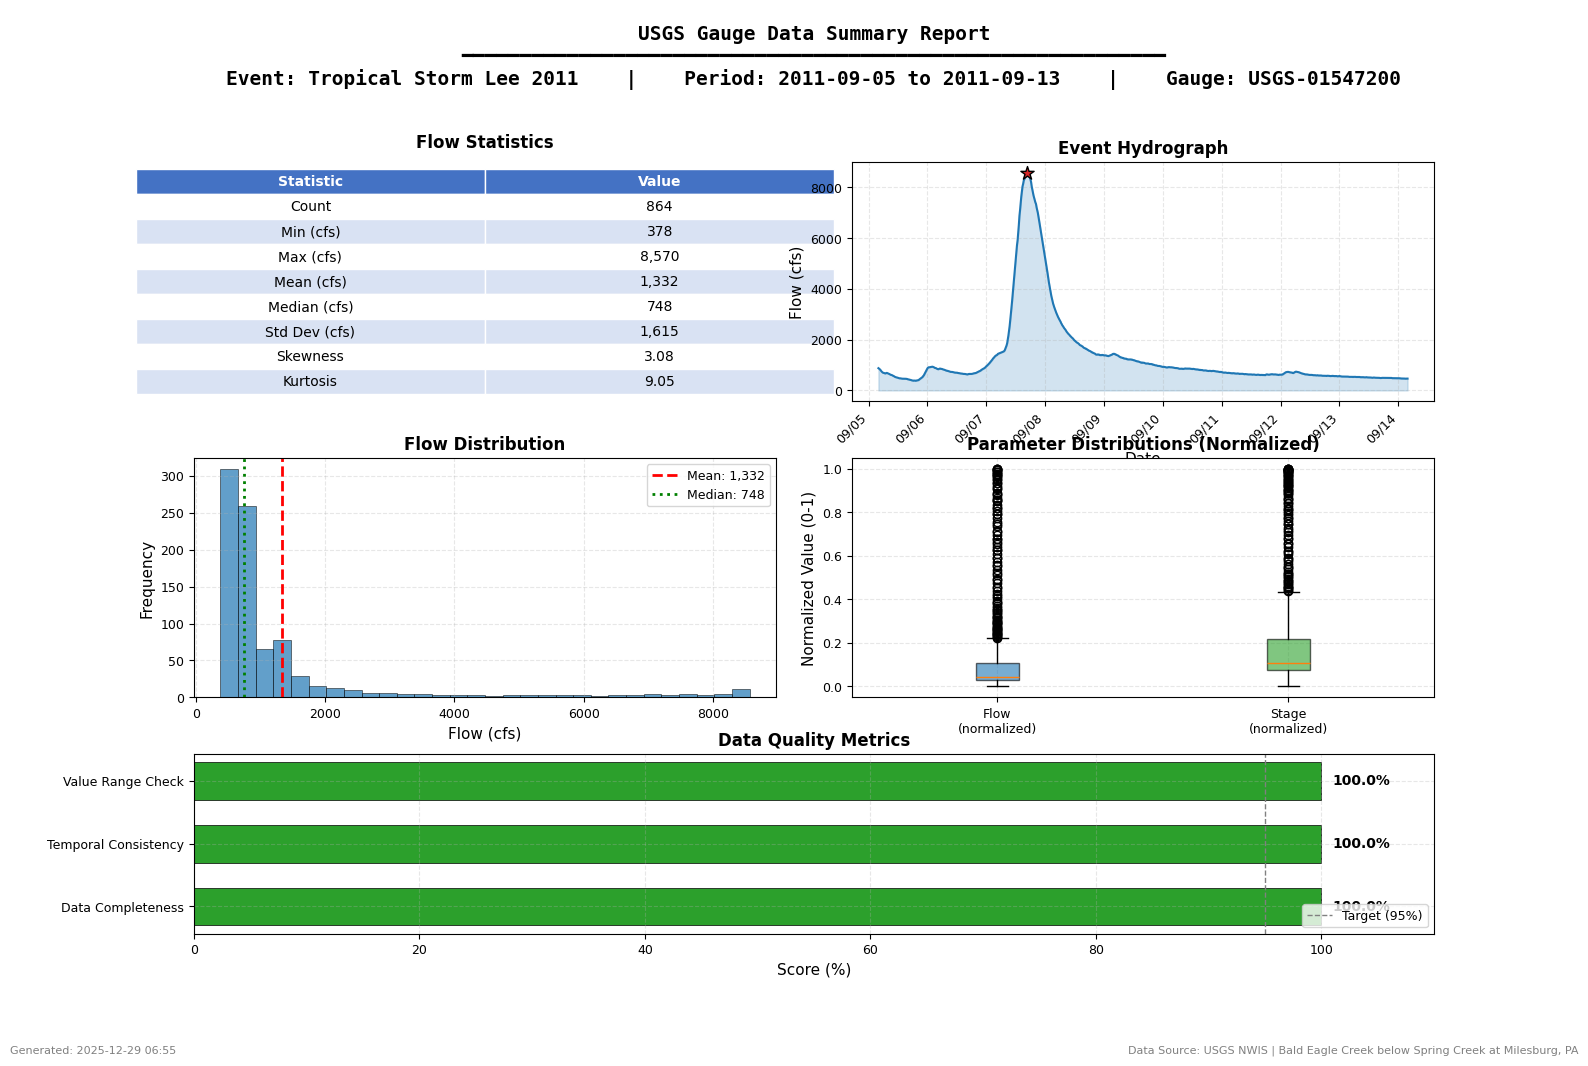

In [48]:
# =============================================================================
# FIGURE E1: COMPREHENSIVE SUMMARY STATISTICS DASHBOARD
# =============================================================================

fig = plt.figure(figsize=(16, 12))

gs = gridspec.GridSpec(4, 4, figure=fig, height_ratios=[0.8, 2, 2, 1.5],
                       hspace=0.3, wspace=0.3)

# ==========================================================================
# Header Row
# ==========================================================================
ax_header = fig.add_subplot(gs[0, :])
ax_header.axis('off')

header_text = (
    f"USGS Gauge Data Summary Report\n"
    f"{'━' * 60}\n"
    f"Event: {event_name.replace('_', ' ')}    |    "
    f"Period: {event_start.strftime('%Y-%m-%d')} to {event_end.strftime('%Y-%m-%d')}    |    "
    f"Gauge: USGS-{upstream_site}"
)
ax_header.text(0.5, 0.5, header_text, ha='center', va='center',
               fontsize=14, fontfamily='monospace', fontweight='bold')

# ==========================================================================
# Flow Statistics Table (Row 1, Left)
# ==========================================================================
ax_flow_stats = fig.add_subplot(gs[1, 0:2])
ax_flow_stats.axis('off')

flow_stats = {
    'Count': f"{len(upstream_flow):,}",
    'Min (cfs)': f"{upstream_flow['value'].min():,.0f}",
    'Max (cfs)': f"{upstream_flow['value'].max():,.0f}",
    'Mean (cfs)': f"{upstream_flow['value'].mean():,.0f}",
    'Median (cfs)': f"{upstream_flow['value'].median():,.0f}",
    'Std Dev (cfs)': f"{upstream_flow['value'].std():,.0f}",
    'Skewness': f"{stats.skew(upstream_flow['value']):.2f}",
    'Kurtosis': f"{stats.kurtosis(upstream_flow['value']):.2f}",
}

table_data = [[k, v] for k, v in flow_stats.items()]
table = ax_flow_stats.table(cellText=table_data,
                             colLabels=['Statistic', 'Value'],
                             cellLoc='center', loc='center', colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#4472C4')
        cell.set_text_props(color='white', fontweight='bold')
    elif i % 2 == 0:
        cell.set_facecolor('#D9E2F3')
    cell.set_edgecolor('white')

ax_flow_stats.set_title('Flow Statistics', fontweight='bold', fontsize=12, pad=10)

# ==========================================================================
# Mini Hydrograph (Row 1, Right)
# ==========================================================================
ax_mini_hydro = fig.add_subplot(gs[1, 2:4])

ax_mini_hydro.plot(upstream_flow['datetime'], upstream_flow['value'],
                   color=COLORS['flow'], linewidth=1.5)
ax_mini_hydro.fill_between(upstream_flow['datetime'], upstream_flow['value'],
                           alpha=0.2, color=COLORS['flow'])

peak_idx = upstream_flow['value'].idxmax()
peak_flow_val = upstream_flow.loc[peak_idx, 'value']
peak_time_val = upstream_flow.loc[peak_idx, 'datetime']
ax_mini_hydro.scatter([peak_time_val], [peak_flow_val], color=COLORS['peak'],
                      s=100, marker='*', zorder=5, edgecolors='black')

ax_mini_hydro.set_title('Event Hydrograph', fontweight='bold', fontsize=12)
ax_mini_hydro.set_xlabel('Date')
ax_mini_hydro.set_ylabel('Flow (cfs)')
ax_mini_hydro.grid(True, alpha=0.3)
format_datetime_axis(ax_mini_hydro, date_format='%m/%d')

# ==========================================================================
# Flow Histogram (Row 2, Left)
# ==========================================================================
ax_hist = fig.add_subplot(gs[2, 0:2])

n, bins_hist, patches_hist = ax_hist.hist(upstream_flow['value'], bins=30,
                                           color=COLORS['flow'], edgecolor='black',
                                           alpha=0.7, linewidth=0.5)

ax_hist.axvline(upstream_flow['value'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {upstream_flow["value"].mean():,.0f}')
ax_hist.axvline(upstream_flow['value'].median(), color='green', linestyle=':',
                linewidth=2, label=f'Median: {upstream_flow["value"].median():,.0f}')

ax_hist.set_title('Flow Distribution', fontweight='bold', fontsize=12)
ax_hist.set_xlabel('Flow (cfs)')
ax_hist.set_ylabel('Frequency')
ax_hist.legend(loc='upper right', fontsize=9)
ax_hist.grid(True, alpha=0.3, axis='y')

# ==========================================================================
# Box Plot (Row 2, Right)
# ==========================================================================
ax_box = fig.add_subplot(gs[2, 2:4])

flow_norm = (upstream_flow['value'] - upstream_flow['value'].min()) / \
            (upstream_flow['value'].max() - upstream_flow['value'].min())

box_data = [flow_norm.dropna()]
labels = ['Flow\n(normalized)']

if not upstream_stage.empty:
    stage_norm = (upstream_stage['value'] - upstream_stage['value'].min()) / \
                 (upstream_stage['value'].max() - upstream_stage['value'].min())
    box_data.append(stage_norm.dropna())
    labels.append('Stage\n(normalized)')

bp = ax_box.boxplot(box_data, labels=labels, patch_artist=True)

colors_box = [COLORS['flow'], COLORS['stage']]
for patch, color in zip(bp['boxes'], colors_box[:len(box_data)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax_box.set_title('Parameter Distributions (Normalized)', fontweight='bold', fontsize=12)
ax_box.set_ylabel('Normalized Value (0-1)')
ax_box.grid(True, alpha=0.3, axis='y')

# ==========================================================================
# Data Quality Bar (Bottom Row)
# ==========================================================================
ax_quality = fig.add_subplot(gs[3, :])

event_duration_q = (upstream_flow['datetime'].max() - upstream_flow['datetime'].min())
expected_records_q = int(event_duration_q.total_seconds() / (15 * 60)) + 1
completeness_q = len(upstream_flow) / expected_records_q * 100 if expected_records_q > 0 else 0

time_diffs_q = upstream_flow['datetime'].diff()
gap_threshold_q = pd.Timedelta(minutes=45)
gap_count_q = len(time_diffs_q[time_diffs_q > gap_threshold_q])

metrics = {
    'Data Completeness': completeness_q,
    'Temporal Consistency': 100 - (gap_count_q / len(upstream_flow) * 100) if len(upstream_flow) > 0 else 0,
    'Value Range Check': 100 if upstream_flow['value'].min() >= 0 else 50,
}

y_pos = range(len(metrics))
bars_q = ax_quality.barh(y_pos, metrics.values(), color=COLORS['flow'],
                         edgecolor='black', linewidth=0.5, height=0.6)

for bar, val in zip(bars_q, metrics.values()):
    if val >= 95:
        bar.set_facecolor(COLORS['good'])
    elif val >= 80:
        bar.set_facecolor(COLORS['warning'])
    else:
        bar.set_facecolor(COLORS['bad'])
    ax_quality.text(val + 1, bar.get_y() + bar.get_height()/2,
                    f'{val:.1f}%', va='center', fontweight='bold')

ax_quality.set_yticks(y_pos)
ax_quality.set_yticklabels(metrics.keys())
ax_quality.set_xlim(0, 110)
ax_quality.set_xlabel('Score (%)')
ax_quality.set_title('Data Quality Metrics', fontweight='bold', fontsize=12)
ax_quality.axvline(95, color='gray', linestyle='--', linewidth=1, label='Target (95%)')
ax_quality.grid(True, alpha=0.3, axis='x')
ax_quality.legend(loc='lower right')

# Footer
fig.text(0.01, 0.01, f'Generated: {pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")}',
         fontsize=8, color='gray')
fig.text(0.99, 0.01, f'Data Source: USGS NWIS | {target_gauges["upstream"]["name"]}',
         ha='right', fontsize=8, color='gray')

fig.savefig(plots_dir / f'{event_name}_summary_dashboard.png', 
            dpi=150, bbox_inches='tight', facecolor='white')
print(f"Saved: {plots_dir / f'{event_name}_summary_dashboard.png'}")
plt.show()

### 9.5 QAQC Visualization Summary

In [49]:
# =============================================================================
# QAQC VISUALIZATION SUMMARY
# =============================================================================

print("=" * 70)
print("USGS GAUGE DATA QAQC VISUALIZATION - SUMMARY")
print("=" * 70)

print(f"\nEvent: {event_name.replace('_', ' ')}")
print(f"Gauge: USGS-{upstream_site}")
print(f"Period: {event_start} to {event_end}")

print(f"\nGenerated Figures:")
print(f"  [A1] Data Quality Dashboard - Gap detection, completeness, intervals")
print(f"  [B1] Event Hydrograph - Dual-axis with peak/IC annotations")
print(f"  [D1] Rating Curve - Stage-discharge with power law fit")
print(f"  [E1] Summary Dashboard - Comprehensive statistics for reports")

print(f"\nOutput Directory: {plots_dir}")
print(f"\nFigure Files:")
for f in sorted(plots_dir.glob(f'{event_name}*.png')):
    print(f"  - {f.name}")

print("\n" + "=" * 70)
print("QAQC Visualization Complete - Figures ready for engineering reports")
print("=" * 70)

USGS GAUGE DATA QAQC VISUALIZATION - SUMMARY

Event: Tropical Storm Lee 2011
Gauge: USGS-01547200
Period: 2011-09-05 00:00:00 to 2011-09-13 00:00:00

Generated Figures:
  [A1] Data Quality Dashboard - Gap detection, completeness, intervals
  [B1] Event Hydrograph - Dual-axis with peak/IC annotations
  [D1] Rating Curve - Stage-discharge with power law fit
  [E1] Summary Dashboard - Comprehensive statistics for reports

Output Directory: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_911\gauge_data\plots

Figure Files:
  - Tropical_Storm_Lee_2011_data_quality_dashboard.png
  - Tropical_Storm_Lee_2011_hydrograph.png
  - Tropical_Storm_Lee_2011_rating_curve.png
  - Tropical_Storm_Lee_2011_summary_dashboard.png

QAQC Visualization Complete - Figures ready for engineering reports
